<a href="https://colab.research.google.com/github/dayangalyssa/bakpropagation-heart-disease/blob/main/BACKPROPAGATION_HEART_DISEASE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import numpy as np
import pandas as pd

In [2]:
uploaded = files.upload()

Saving heart_disease_dataset.csv to heart_disease_dataset.csv


In [3]:
for filename in uploaded.keys():
    print(f"File '{filename}'")

    df = pd.read_csv(filename)
    print(df.head())

File 'heart_disease_dataset.csv'
   Age  Gender  Cholesterol  Blood Pressure  Heart Rate  Smoking  \
0   75  Female          228             119          66  Current   
1   48    Male          204             165          62  Current   
2   53    Male          234              91          67    Never   
3   69  Female          192              90          72  Current   
4   62  Female          172             163          93    Never   

  Alcohol Intake  Exercise Hours Family History Diabetes Obesity  \
0          Heavy               1             No       No     Yes   
1            NaN               5             No       No      No   
2          Heavy               3            Yes       No     Yes   
3            NaN               4             No      Yes      No   
4            NaN               6             No      Yes      No   

   Stress Level  Blood Sugar Exercise Induced Angina   Chest Pain Type  \
0             8          119                     Yes   Atypical Angina   
1

#  EDA dan Pre-Processing

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      1000 non-null   int64 
 1   Gender                   1000 non-null   object
 2   Cholesterol              1000 non-null   int64 
 3   Blood Pressure           1000 non-null   int64 
 4   Heart Rate               1000 non-null   int64 
 5   Smoking                  1000 non-null   object
 6   Alcohol Intake           660 non-null    object
 7   Exercise Hours           1000 non-null   int64 
 8   Family History           1000 non-null   object
 9   Diabetes                 1000 non-null   object
 10  Obesity                  1000 non-null   object
 11  Stress Level             1000 non-null   int64 
 12  Blood Sugar              1000 non-null   int64 
 13  Exercise Induced Angina  1000 non-null   object
 14  Chest Pain Type          1000 non-null   

In [5]:
print(df.describe())

               Age  Cholesterol  Blood Pressure   Heart Rate  Exercise Hours  \
count  1000.000000  1000.000000       1000.0000  1000.000000     1000.000000   
mean     52.293000   249.939000        135.2810    79.204000        4.529000   
std      15.727126    57.914673         26.3883    11.486092        2.934241   
min      25.000000   150.000000         90.0000    60.000000        0.000000   
25%      39.000000   200.000000        112.7500    70.000000        2.000000   
50%      52.000000   248.000000        136.0000    79.000000        4.500000   
75%      66.000000   299.000000        159.0000    89.000000        7.000000   
max      79.000000   349.000000        179.0000    99.000000        9.000000   

       Stress Level  Blood Sugar  Heart Disease  
count   1000.000000  1000.000000    1000.000000  
mean       5.646000   134.941000       0.392000  
std        2.831024    36.699624       0.488441  
min        1.000000    70.000000       0.000000  
25%        3.000000   104.000

In [6]:
print(df.isnull().sum())

Age                          0
Gender                       0
Cholesterol                  0
Blood Pressure               0
Heart Rate                   0
Smoking                      0
Alcohol Intake             340
Exercise Hours               0
Family History               0
Diabetes                     0
Obesity                      0
Stress Level                 0
Blood Sugar                  0
Exercise Induced Angina      0
Chest Pain Type              0
Heart Disease                0
dtype: int64


In [7]:
df['Alcohol Intake'] = df['Alcohol Intake'].fillna(df['Alcohol Intake'].mode()[0])

In [8]:
print(df.isnull().sum())

Age                        0
Gender                     0
Cholesterol                0
Blood Pressure             0
Heart Rate                 0
Smoking                    0
Alcohol Intake             0
Exercise Hours             0
Family History             0
Diabetes                   0
Obesity                    0
Stress Level               0
Blood Sugar                0
Exercise Induced Angina    0
Chest Pain Type            0
Heart Disease              0
dtype: int64


## Target

<ipython-input-9-b9e8b9a3c4b0>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Heart Disease', data=df, palette='pastel')


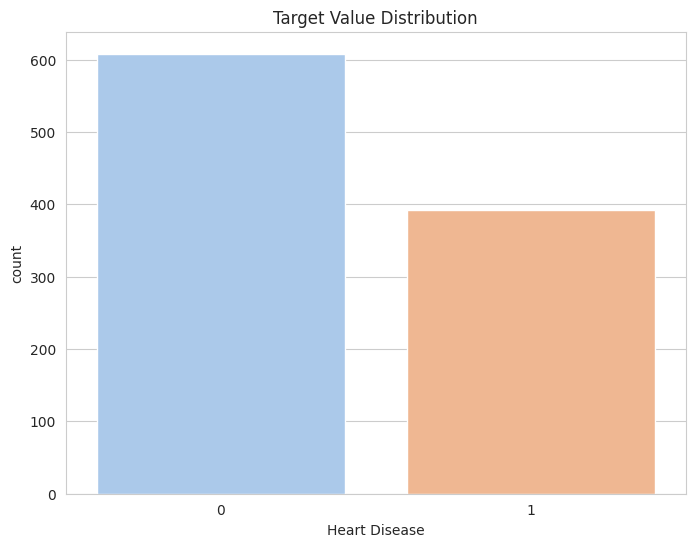

Heart Disease
0    608
1    392
Name: count, dtype: int64


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(8,6))
sns.countplot(x='Heart Disease', data=df, palette='pastel')
plt.title('Target Value Distribution')
plt.show()

target_temp = df['Heart Disease'].value_counts()
print(target_temp)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [11]:
categorical_cols = ['Gender', 'Smoking', 'Alcohol Intake', 'Family History',
                    'Diabetes', 'Obesity', 'Exercise Induced Angina', 'Chest Pain Type']
data = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = data.drop(columns=['Heart Disease'])
y = data['Heart Disease']

In [12]:
X = X.astype({col: 'int' for col in X.select_dtypes(include=['bool']).columns})

numeric_cols = X.select_dtypes(include=['int', 'float']).columns
X[numeric_cols] = (X[numeric_cols] - X[numeric_cols].min()) / (X[numeric_cols].max() - X[numeric_cols].min())

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

y_train_onehot = np.eye(2)[y_train]
y_test_onehot = np.eye(2)[y_test]


# Fungsi Backpropagation

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def sig(x):
    return 1 / (1 + np.exp(-np.clip(x, -100, 100)))

def sigd(x):
    s = sig(x)
    return s * (1 - s)

def bp_fit(X, target, layer_conf, max_epoch, max_error=0.01, learn_rate=0.01, print_per_epoch=100):
    np.random.seed(1)

    nin = [np.empty(i) for i in layer_conf]
    n = [np.empty(j + 1) if i < len(layer_conf) - 1 else np.empty(j) for i, j in enumerate(layer_conf)]

    w = [np.random.rand(layer_conf[i] + 1, layer_conf[i + 1]) for i in range(len(layer_conf) - 1)]
    dw = [np.empty((layer_conf[i] + 1, layer_conf[i + 1])) for i in range(len(layer_conf) - 1)]
    d = [np.empty(s) for s in layer_conf[1:]]
    din = [np.empty(s) for s in layer_conf[1:-1]]

    epoch = 0
    mse = 1
    mse_history = []

    for i in range(0, len(n) - 1):
        n[i][-1] = 1

    while (max_epoch == -1 or epoch < max_epoch) and mse > max_error:
        epoch += 1
        mse = 0

        for r in range(len(X)):
            n[0][:-1] = X[r]

            for L in range(1, len(layer_conf)):
                nin[L] = np.dot(n[L-1], w[L-1])
                n[L][:len(nin[L])] = sig(nin[L])

            e = target[r] - n[-1]
            mse += sum(e ** 2)
            d[-1] = e * sigd(nin[-1])
            dw[-1] = learn_rate * d[-1] * n[-2].reshape((-1, 1))

            for L in range(len(layer_conf) - 1, 1, -1):
                din[L-2] = np.dot(d[L-1], np.transpose(w[L-1][:-1]))
                d[L-2] = din[L-2] * np.array(sigd(nin[L-1]))
                dw[L-2] = learn_rate * d[L-2] * n[L-2].reshape((-1, 1))

            for i in range(len(w)):
                w[i] += dw[i]

        mse /= len(X)
        mse_history.append(mse)

        if print_per_epoch > -1 and epoch % print_per_epoch == 0:
            print(f'Epoch {epoch}, MSE: {mse}')

    return w, epoch, mse, mse_history

def bp_predict(X, w):
    n = [np.empty(len(i)) for i in w]
    nin = [np.empty(len(i[0])) for i in w]
    predict = []
    n.append(np.empty(len(w[-1][0])))

    for x in X:
        n[0][:-1] = x
        for L in range(0, len(w)):
            nin[L] = np.dot(n[L], w[L])
            n[L + 1][:len(nin[L])] = sig(nin[L])
        predict.append(n[-1].copy())

    return predict

# Pelatihan dan Prediksi

In [14]:
input_size = X_train.shape[1]
hidden_layer = 10
output_size = 2
layer_conf = [input_size, hidden_layer, output_size]

In [15]:
print("\Proses Training...")
weights, epochs, mse, mse_history = bp_fit(X_train, y_train_onehot, layer_conf, max_epoch=1000, max_error=0.01)

print(f"\nTotal Epochs: {epochs}, MSE: {mse}")

predict = bp_predict(X_train, weights)
predict_labels = np.argmax(predict, axis=1)
y_train_labels = np.argmax(y_train_onehot, axis=1)

accuracy = accuracy_score(predict_labels, y_train_labels)

print("\nOutput Prediksi:", predict_labels)
print("Target Sebenarnya:", y_train_labels)
print(f"Akurasi: {accuracy:.4f}")

\Proses Training...
Epoch 100, MSE: 0.4757172129897278
Epoch 200, MSE: 0.2398450063102732
Epoch 300, MSE: 0.18066788931633115
Epoch 400, MSE: 0.17524074596679945
Epoch 500, MSE: 0.17385827125172745
Epoch 600, MSE: 0.17312046317081556
Epoch 700, MSE: 0.17235485042607843
Epoch 800, MSE: 0.1711326716136524
Epoch 900, MSE: 0.16884973942480805
Epoch 1000, MSE: 0.16435617288383345

Total Epochs: 1000, MSE: 0.16435617288383345

Output Prediksi: [1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0
 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0
 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0
 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 

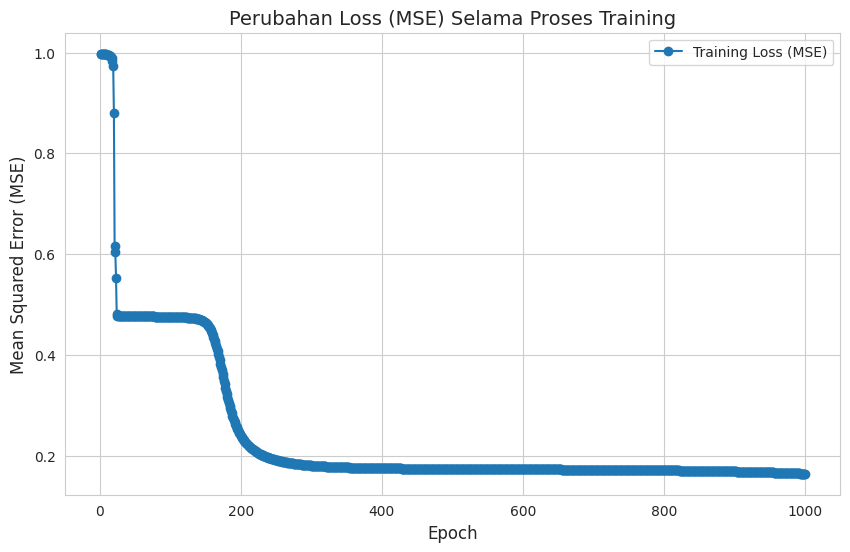

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_history) + 1), mse_history, marker='o', label='Training Loss (MSE)')
plt.title('Perubahan Loss (MSE) Selama Proses Training', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_prob = bp_predict(X_test, weights)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.855

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       118
           1       0.86      0.77      0.81        82

    accuracy                           0.85       200
   macro avg       0.86      0.84      0.85       200
weighted avg       0.86      0.85      0.85       200

